# Objectif

Classer en 6 catégories le signal en 2ème position de chaque ensemble de signaux présent dans un dossier

Voici les 6 catégories : 
- Sinus en phase        (SP)
- Sinus en déphase      (SD)
- Triangle en phase     (TP)
- Triangle en déphase   (TD)
- Signal qui ondule     (SO)
- Autres                (AU)

# Import

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

import os
import shutil


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import scipy
from scipy.signal import find_peaks

import inspect
from tqdm import tqdm


# Importer les signaux

In [ ]:
def get_data_from_file(filepath, seq_len):
    data = scipy.io.loadmat(filepath)
    return data['voltage'][0][:seq_len].astype(np.float64), data['current'][0][:seq_len].astype(np.float64), data['f1'][0][:seq_len].astype(np.float64), data['f2'][0][:seq_len].astype(np.float64), data['f3'][0][:seq_len].astype(np.float64)


def generate_data(dossier, seq_len=1900, nb_channel=5):

    data = []
    
    for file in os.listdir(dossier):
        filepath = os.path.join(dossier, file)
        if os.path.isfile(filepath):
            data_v, data_c, data_f1, data_f2, data_f3 = get_data_from_file(filepath, seq_len)
            list_data_from_file = [data_v, data_c, data_f1, data_f2, data_f3]

            data.append(list_data_from_file)

    nb_files = len(data)
    return np.array(data).reshape(nb_files, nb_channel, 1, seq_len)

In [ ]:
folder_path = "echantillon"
# folder_path = r"/home/user/Documents/Data/matrix" # Chemin vers le dossier avec toutes la data

seq_len = 1900

In [ ]:
data_echantillon = generate_data(folder_path, seq_len=seq_len)

In [ ]:
data_echantillon.shape

# Détermination de la phase

In [ ]:
# Renvoie True si le signal est phasé
# Renvoie False si il est déphasé
def determine_phase(signal, nb_point_a_check=10):

    len_signal = signal.shape[2]

    score_phase = 0

    for _ in range(nb_point_a_check):

        pt_random = np.random.randint(0, len_signal)

        if signal[0][0][pt_random]*signal[1][0][pt_random] > 0 :
            score_phase += 1
        else:
            score_phase -= 1
    
    if score_phase >= 0:
        return True
    else:
        return False

# Test sur des signaux au hasard

In [ ]:
def affichage_data(signal, seq_len=1900, nb_channels=5, info_text="Signal"):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(20, 8), sharex=True)

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[i].reshape(seq_len), label=f'Signal {i+1}')
        axs[i].grid()
    
    plt.suptitle(info_text)
    plt.show()

In [ ]:
signal_hasard = np.random.randint(0, data_echantillon.shape[0])

phase = determine_phase(data_echantillon[signal_hasard])

affichage_data(data_echantillon[signal_hasard], seq_len=seq_len, nb_channels=2, info_text="Phase" if phase==True else "Déphase")

# Detection signaux triangle

In [ ]:
# Fonction pour analyser le signal avec la FFT
def analyze_signal(signal):
    N = len(signal)
    freq = np.fft.fftfreq(N)
    fft_values = np.fft.fft(signal)
    return freq[:N//2], np.abs(fft_values[:N//2])

In [ ]:
def affichage_signal_fft(signal, freq_sin, fft_sin):
    # Créer une figure avec deux subplots
    plt.figure(figsize=(16, 8))

    # Subplot 1 : Signal Sinus
    plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, 1ère position
    plt.plot(signal, label='Signal Sinus')
    plt.title('Signal Sinus')
    plt.xlabel('Temps [s]')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()

    # Subplot 2 : Spectre FFT Signal Sinus
    plt.subplot(2, 1, 2)  # 2 lignes, 1 colonne, 2ème position
    plt.plot(freq_sin, fft_sin, label='FFT Signal Sinus')
    plt.title('Spectre FFT Signal Sinus')
    plt.xlabel('Fréquence [Hz]')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()

    # Afficher la figure
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

In [ ]:
def normalize_signal(signal):
    min_signal = np.min(signal)
    max_signal = np.max(signal)
    return (signal - min_signal) / (max_signal - min_signal)

In [ ]:
def determine_triangle(signal, affichage=True):
    sin_signal = signal[1, 0]

    sin_signal = normalize_signal(sin_signal)

    freq_sin, fft_sin = analyze_signal(sin_signal)

    if affichage == True:
        affichage_signal_fft(sin_signal, freq_sin, fft_sin)

    # fft_sin = fft_sin[1:]

    fft_sin = np.sort(fft_sin)[::-1]

    # for i in range(5):
    #     print(fft_sin[i])

    if fft_sin[2] > 30:
        # print("Le signal est un triangle")
        return True
    else:
        # print("Le signal n'est pas un triangle")
        return False

# Test sur des signaux au hasard

In [ ]:
indice = np.random.randint(0, data_echantillon.shape[0])
determine_triangle(data_echantillon[indice])

# Classification ondulation

In [ ]:
def determine_ondulation(signal, num_intervals=5):
    sin_signal = signal[1, 0]

    sin_signal = normalize_signal(sin_signal)

    # Découpe le signal en 'num_intervals'
    interval_length = len(sin_signal) // num_intervals
    max_values = []

    for i in range(num_intervals):
        start = i * interval_length
        # Pour le dernier intervalle, on prend jusqu'à la fin du signal
        end = start + interval_length if i < num_intervals - 1 else len(sin_signal)
        interval = sin_signal[start:end]
        max_values.append(np.max(interval))

    # Vérifie si tous les max sont inférieurs à 0.8
    return min(max_values)


# Test Identification Ondulation

In [ ]:
while True:
    indice = np.random.randint(0, data_echantillon.shape[0])
    valeur_ondulation = determine_ondulation(data_echantillon[indice])
    if valeur_ondulation < 0.9 and valeur_ondulation > 0.8:
        affichage_data(data_echantillon[indice], nb_channels=2)
        break

# Test Bizarre

In [ ]:
while True:
    indice = np.random.randint(0, data_echantillon.shape[0])
    valeur_ondulation = determine_ondulation(data_echantillon[indice])
    if valeur_ondulation < 0.8:
        affichage_data(data_echantillon[indice], nb_channels=2)
        break

# Classification

In [ ]:
phase_sinus = []
dephase_sinus = []
phase_triangle = []
dephase_triangle = []
ondulation_list = []
bizarre = []

for i in range(data_echantillon.shape[0]):

    phase = determine_phase(data_echantillon[i])
    triangle = determine_triangle(data_echantillon[i], affichage=False)
    ondulation_score = determine_ondulation(data_echantillon[i])

    if ondulation_score < 0.9 and ondulation_score > 0.8:
        ondulation_list.append(data_echantillon[i])
        continue

    if ondulation_score < 0.8:
        bizarre.append(data_echantillon[i])
        continue

    if phase == True:
        if triangle == True:
            phase_triangle.append(data_echantillon[i])
        else:
            phase_sinus.append(data_echantillon[i])
    else:
        if triangle == True:
            dephase_triangle.append(data_echantillon[i])
        else:
            dephase_sinus.append(data_echantillon[i])

# Affichage Stat

In [ ]:
nb_total_signal = data_echantillon.shape[0]

print(f"Nombre de signaux en phase + sinus : {len(phase_sinus)} ({len(phase_sinus)*100/nb_total_signal} %)")
print(f"Nombre de signaux en phase + triangle : {len(phase_triangle)} ({len(phase_triangle)*100/nb_total_signal} %)")
print(f"Nombre de signaux en déphase + sinus : {len(dephase_sinus)} ({len(dephase_sinus)*100/nb_total_signal} %)")
print(f"Nombre de signaux en déphase + triangle : {len(dephase_triangle)} ({len(dephase_triangle)*100/nb_total_signal} %)")

print(f"Nombre de signaux en ondulation : {len(ondulation_list)} ({len(ondulation_list)*100/nb_total_signal} %)")
print(f"Nombre de signaux bizarre : {len(bizarre)} ({len(bizarre)*100/nb_total_signal} %)")

# Exemple de signaux dans chaque catégorie

In [ ]:
def affichage_signaux_categorie(list_categorie, nom_catégories, nb_signaux=5):

    for i in range(min(nb_signaux, len(list_categorie))):
        affichage_data(list_categorie[np.random.randint(0, len(list_categorie))], nb_channels=5, info_text=f"Signal n°{i} de la catégorie {nom_catégories}")


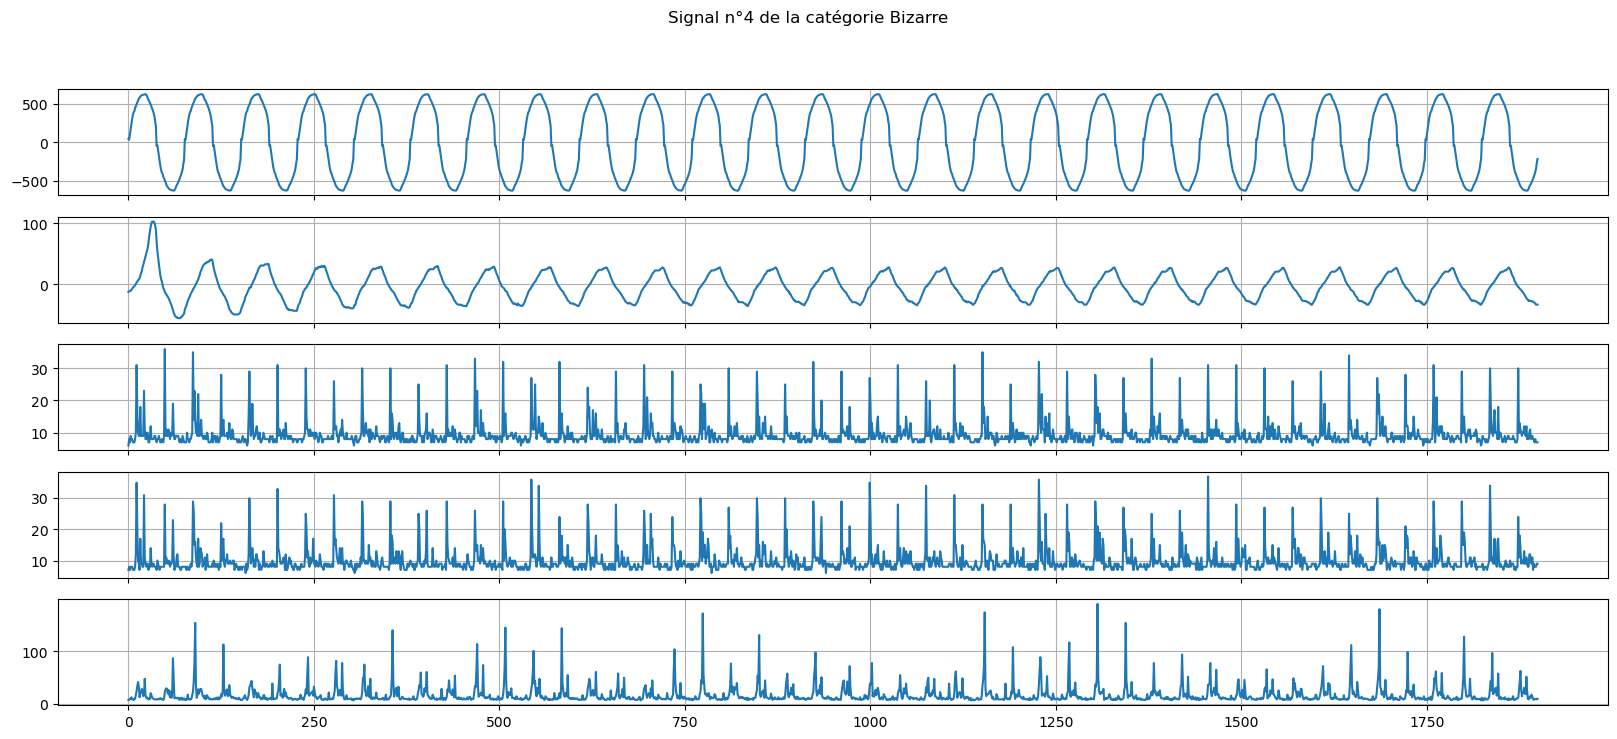

In [20]:
affichage_signaux_categorie(phase_sinus, "Phase + Sinus")
affichage_signaux_categorie(phase_triangle, "Phase + Triangle")
affichage_signaux_categorie(dephase_sinus, "Déphase + Sinus")
affichage_signaux_categorie(dephase_triangle, "Déphase + Triangle")

affichage_signaux_categorie(ondulation_list, "Ondulation")
affichage_signaux_categorie(bizarre, "Bizarre")

# Sauvegarde des sinus

In [21]:
def clean_dir(directory_path):
    if os.path.exists(directory_path):
        # Si le dossier existe, supprime son contenu
        for item in os.listdir(directory_path):
            item_path = os.path.join(directory_path, item)
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Supprime un sous-dossier et son contenu
            else:
                os.remove(item_path)  # Supprime un fichier
    else:
        # Si le dossier n'existe pas, crée le dossier
        os.makedirs(directory_path)

In [22]:
def sauvegarde_signaux_from_list(list_signaux, nom_signaux, save_dir):

    if save_dir not in os.listdir():
        os.mkdir(save_dir)
        print(f"Le dossier {save_dir} vient d'être crée")
    else:
        print(f"Le dossier {save_dir} existe déjà")


    for i in range(len(list_signaux)):

        data = {
            'voltage': list_signaux[i][0],
            'current': list_signaux[i][1],
            'f1': list_signaux[i][2],
            'f2': list_signaux[i][3],
            'f3': list_signaux[i][4],
        }

        # Enregistrer les données sous le même format
        scipy.io.savemat(os.path.join(save_dir, f"{nom_signaux}_{i}.mat"), data)

In [ ]:
def get_variable_name(var):
    frame = inspect.currentframe().f_back
    variables = frame.f_locals.items()
    for name, value in variables:
        if value is var:
            return name
    return None

In [24]:
save_dir = "Cluster Signaux"

In [ ]:
clean_dir(save_dir)

In [ ]:
for liste in tqdm([phase_sinus, dephase_sinus, phase_triangle, dephase_triangle, ondulation_list, bizarre]):
    
    nom_liste = get_variable_name(liste)

    sauvegarde_signaux_from_list(liste, nom_liste, os.path.join(save_dir, nom_liste))


# Test pour les réouvrir

In [25]:
data_bizarre = generate_data(os.path.join(save_dir, "ondulation_list"))

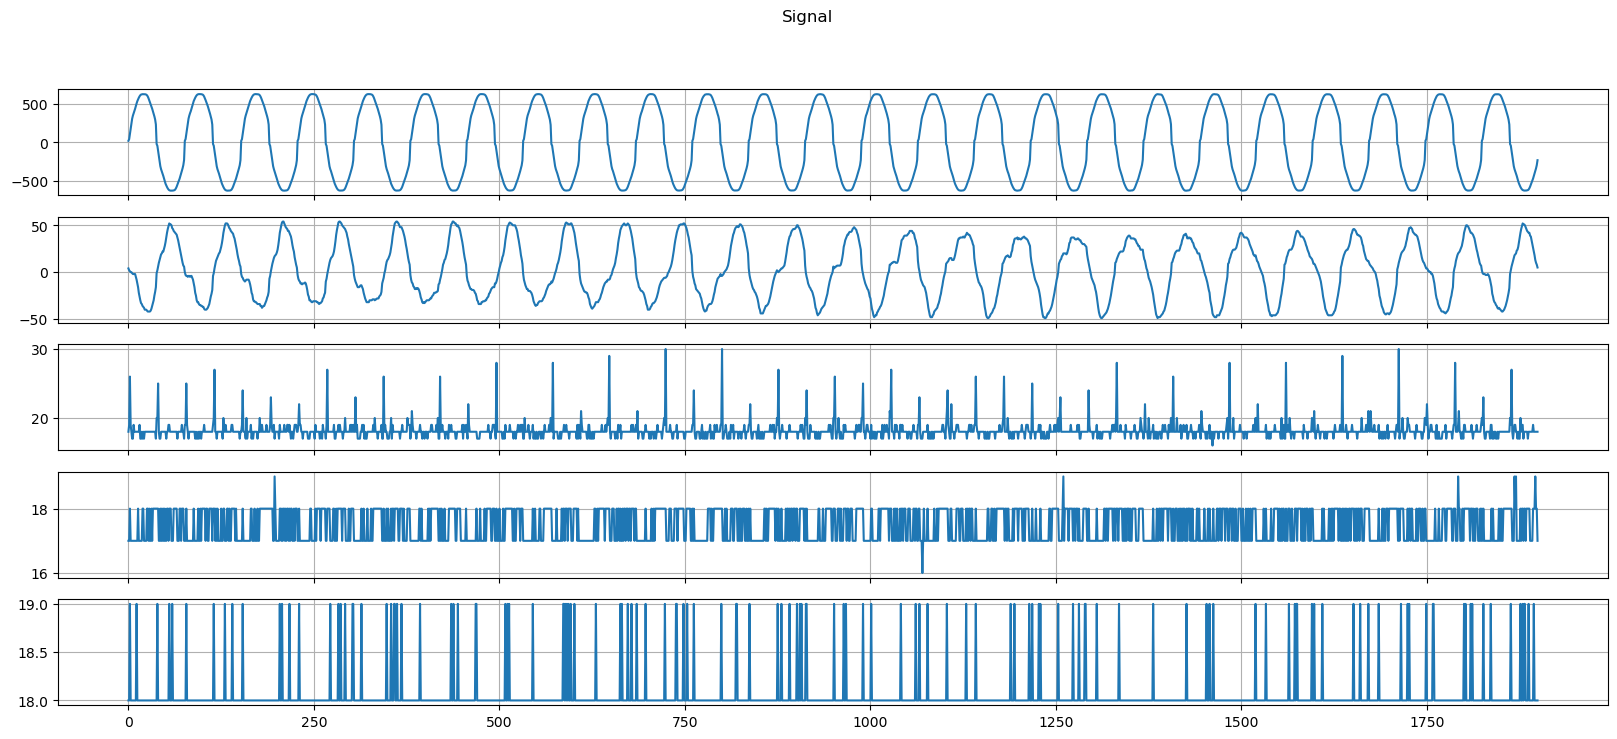

In [32]:
affichage_data(data_bizarre[20])